In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458

In [3]:
working_folder = 'eSR/1RF_1type/uniform_1macro_33bin_noFB_scanI/2.71A/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [4]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

FileNotFoundError: [Errno 2] No such file or directory: '/home/txin/Dropbox/code/Cpp/APES_pack/APES8.2/eSR/1RF_1type/uniform_1macro_33bin_noFB_scanI/2.71A/input.txt'

In [ ]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6

nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]
t_rad_long = tempinput['t_rad_long'][0]
eta = 1/GMTSQ-1/Gamma0**2
if nRF == 1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
if nRF == 2:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

In [ ]:
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh*omega/(omega+1j*QL*(omega0-omega**2/omega0)) # using the convention from A. Chao's book

In [ ]:
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 1*nBunch # number of samples 

mus = np.array([i for i in range(nBunch)])#200#h[0]%nBunch # 
delta_omega_Re = np.zeros(nBunch)
delta_omega_Im = np.zeros(nBunch)
i=0
#print('Mode #, ','Delta_Omega_Re, ','Delta_Omega_Im', 'Growth_Time')
for mu in mus:
    ps = np.array([float(i) for i in range(-pmax,pmax)])
    ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

    # for the calculation of real part of Omega
    p_M_omega0 = ps*nBunch*2*np.pi*f0
    Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
    delta_omegas = 0*factor1*np.sum(p_M_omega0*np.imag(Zs0)) # this is zero if optimumly compensated 
    omegas = Qs*2*pi*f0+delta_omegas

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
    Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[i] = deltaOmegaRe
    delta_omega_Im[i] = deltaOmegaIm
    print(i,deltaOmegaRe+omegas,';',deltaOmegaIm, ';',1/deltaOmegaIm)
    i+=1


In [ ]:
def F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0):
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    return Omega**2-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)

def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1*1j
    Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
    
    Fre = np.real(Err)
    Fim = np.imag(Err)
    dF11 = np.real(F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fre
    dF12 = np.real(F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fre
    dF21 = np.imag(F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fim
    dF22 = np.imag(F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0))-Fim
    det = dF11*dF22-dF12*dF21
    dF11inv = dF22/det
    dF12inv = -dF12/det
    dF21inv = -dF21/det
    dF22inv = dF11/det
    
    OmegaR -= Fre*dF11inv+Fim*dF12inv
    OmegaI -= Fre*dF21inv+Fim*dF22inv
    Omega = OmegaR+OmegaI*1j
    #RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    #LHS = Omega
    
    while(np.abs(Err)>accu and nIter<maxIter):
        OmegaR = np.real(Omega)
        OmegaI = np.imag(Omega)    
        Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
        F1 = F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaRe by a small step
        F2 = F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaIm by a small step
        Fre = np.real(Err)
        Fim = np.imag(Err)
        F1re = np.real(F1)
        F1im = np.imag(F1)
        F2re = np.real(F2)
        F2im = np.imag(F2)
        # approximate the Jacobian
        dF11 = F1re-Fre
        dF12 = F2re-Fre
        dF21 = F1im-Fim
        dF22 = F2im-Fim
        
        det = dF11*dF22-dF12*dF21
        # inverse the Jacobian
        dF11inv = dF22/det
        dF12inv = -dF12/det
        dF21inv = -dF21/det
        dF22inv = dF11/det

        OmegaR -= Fre*dF11inv+Fim*dF12inv
        OmegaI -= Fre*dF21inv+Fim*dF22inv
        Omega = OmegaR+OmegaI*1j
        nIter += 1
    return Omega
    print(Omega)
    print(np.abs(Err))
    print(nIter)

In [ ]:
# Iterative solve:
Omega = -Qs*f0*2*pi
temp = 0
delta_omega_Re_Iter = np.zeros(nBunch)
delta_omega_Im_Iter = np.zeros(nBunch)
idx = 0
for i in range(5):#mus:
    Omega = 0*Qs*f0*2*pi
    temp = SolveOmega(Omega,ps,i,nRF,R,QL[0],omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,3000,1e-15)
    delta_omega_Re_Iter[idx] = np.real(temp)
    delta_omega_Im_Iter[idx] = np.imag(temp)
    idx+=1
    print(i,';',temp)

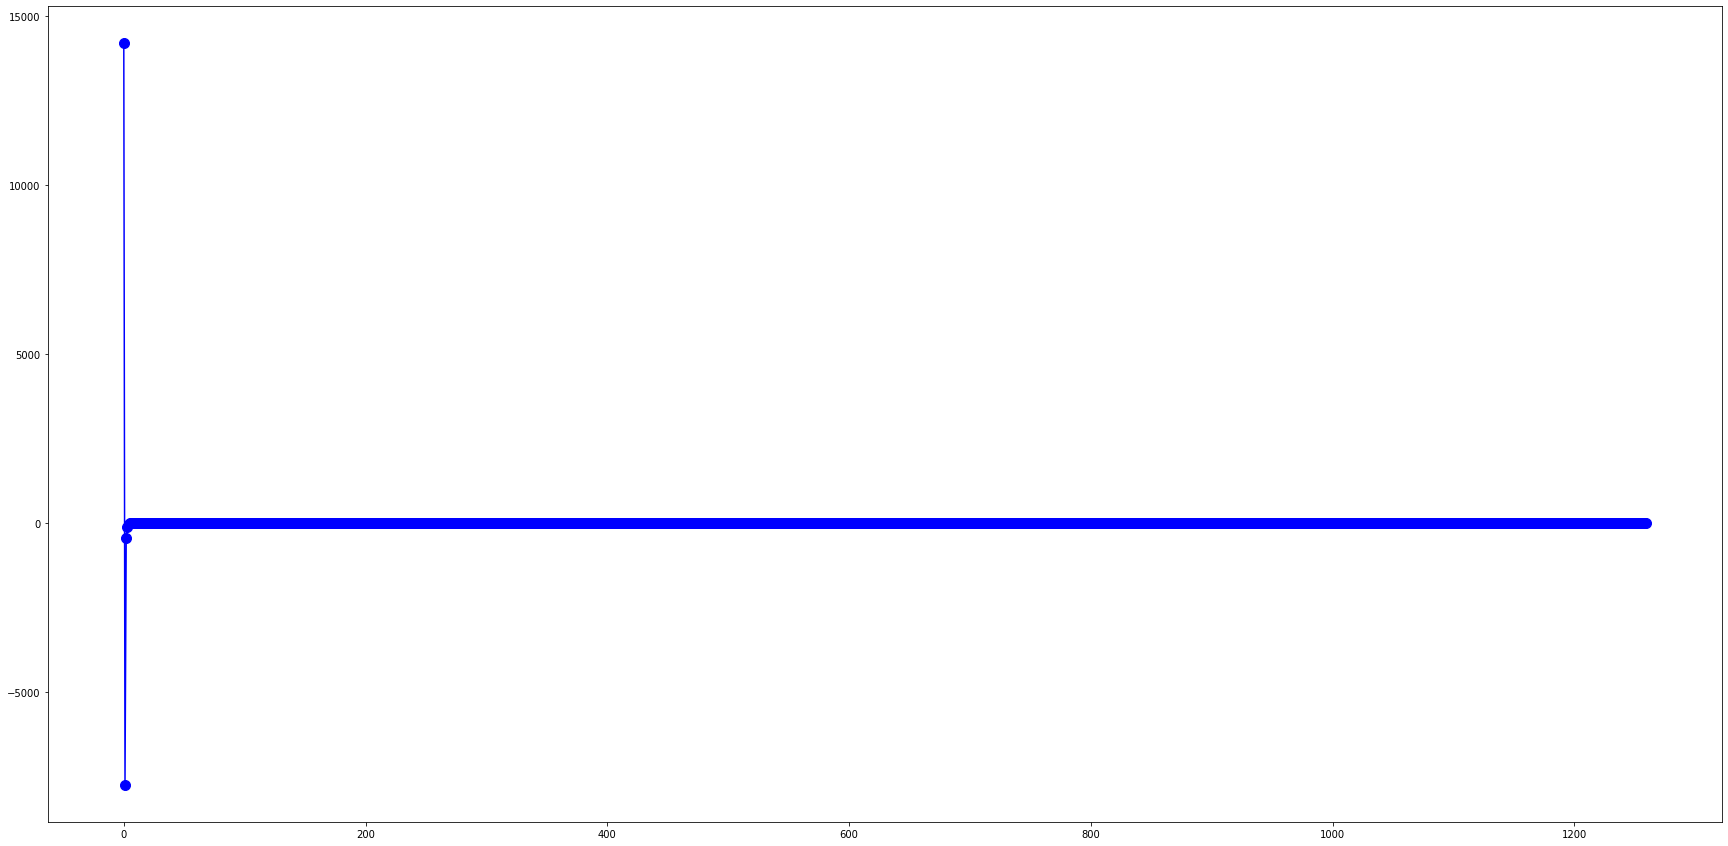

In [1720]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((delta_omega_Im_Iter),'b.-',ms=20)

#axes1.set_ylim([1e4,1e5])
#axes1.set_ylim([-1e-3,1e-3])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

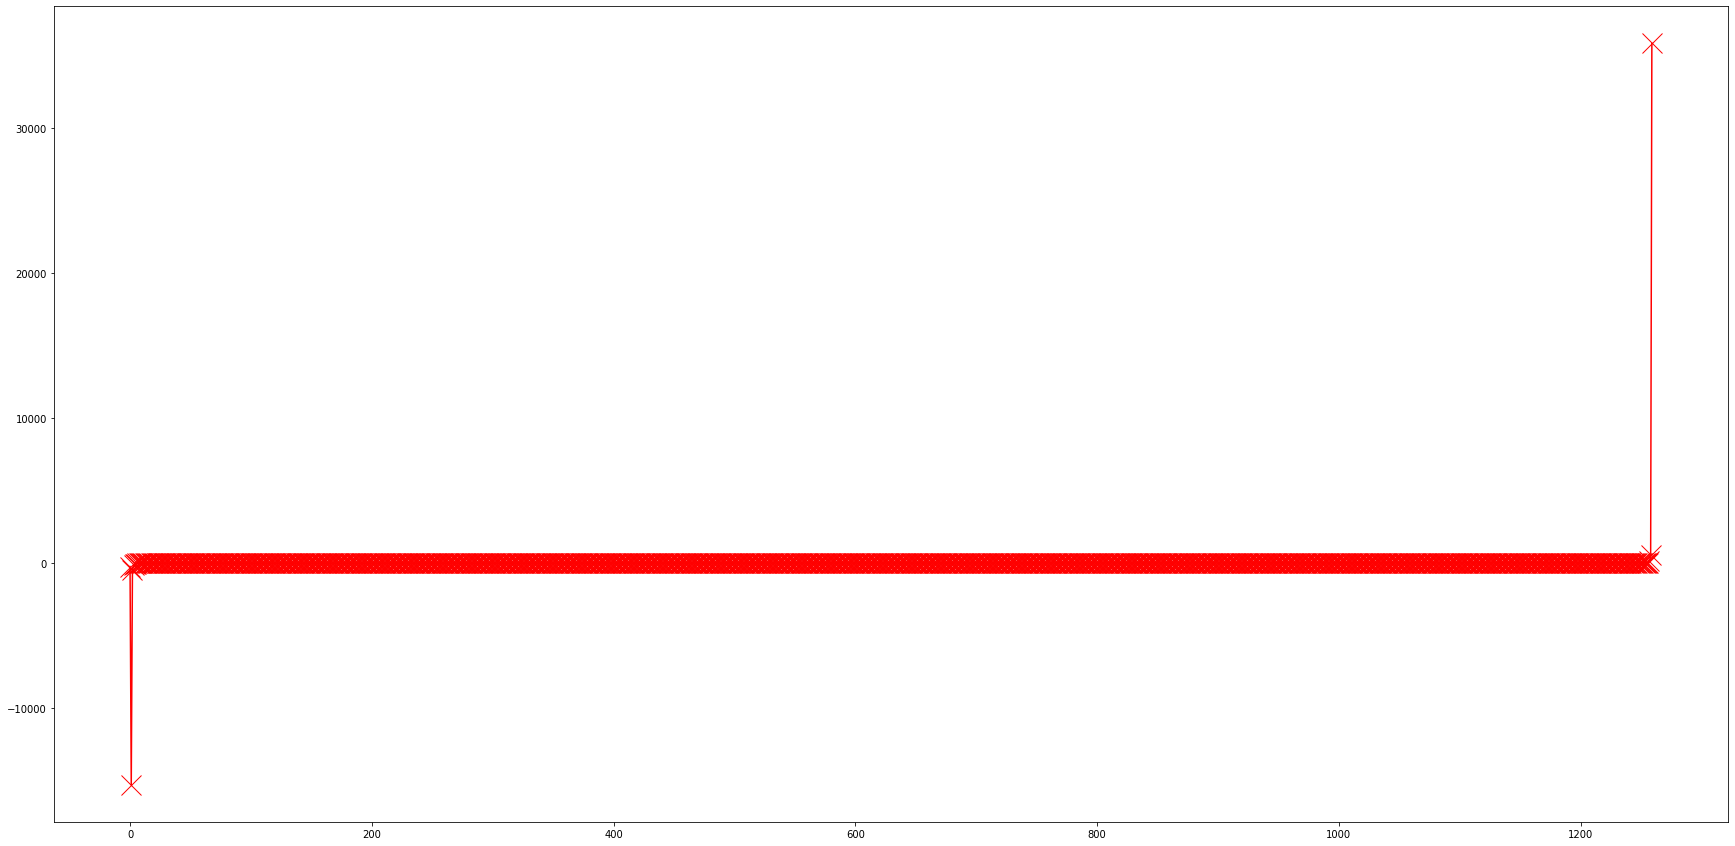

In [1721]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((delta_omega_Im),'rx-',ms=20)

#axes1.set_ylim([1e4,1e5])
#axes1.set_ylim([-1e-6,1e-6])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

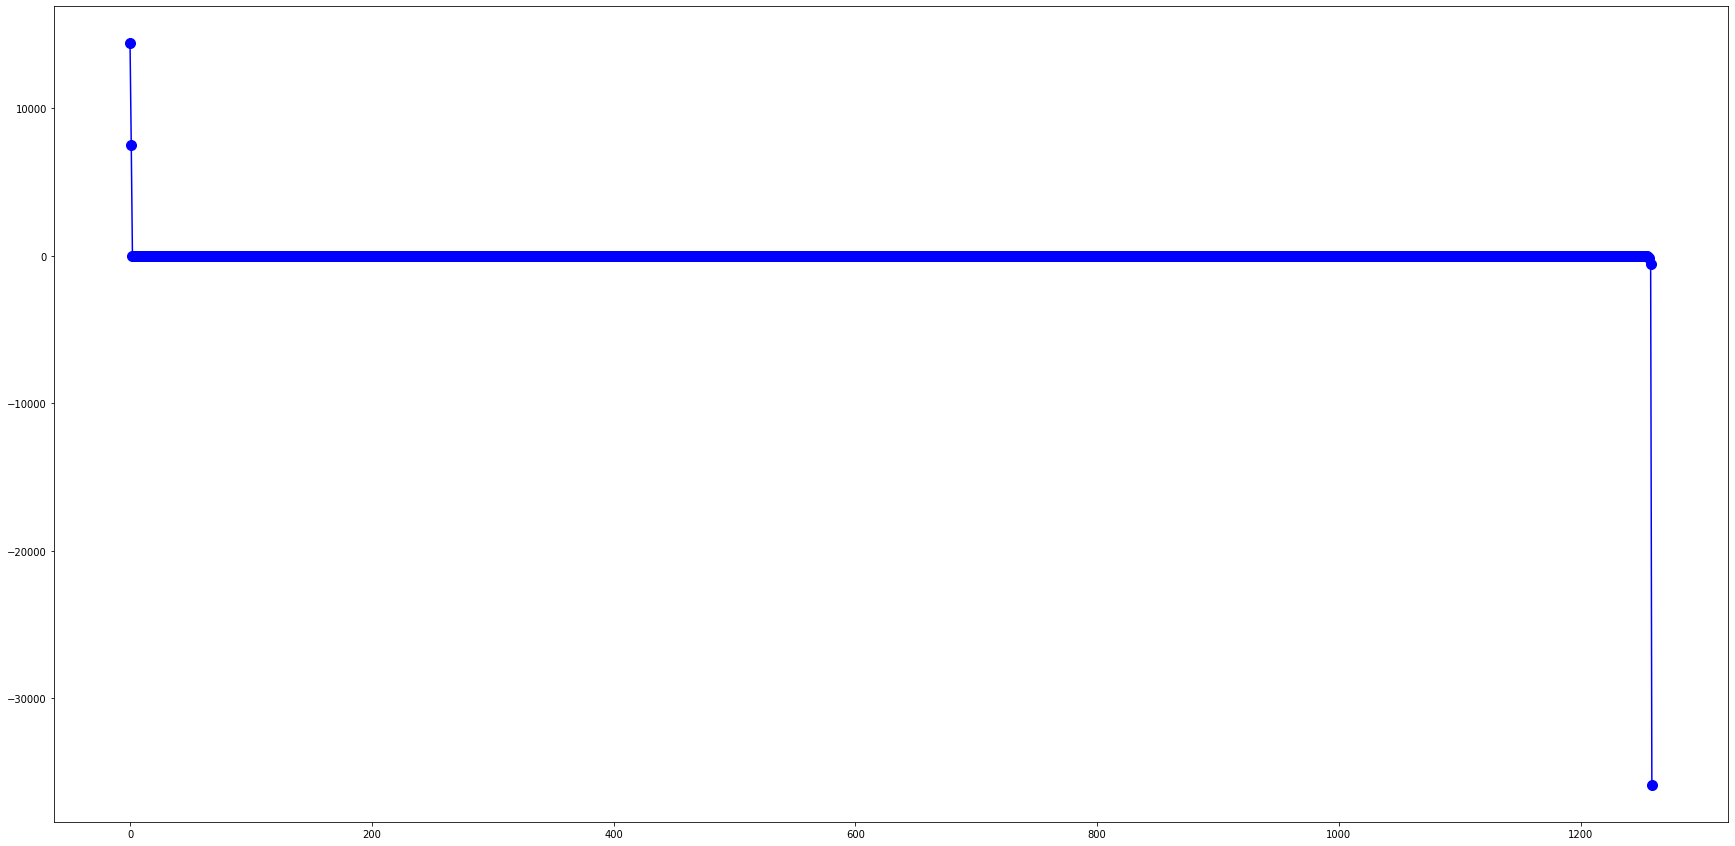

In [1722]:
fig1,axes1 = plt.subplots(1,1)
#axes1.plot((delta_omega_Im),'rx-',ms=20)
axes1.plot((delta_omega_Im_Iter-delta_omega_Im),'b.-',ms=20)

#axes1.set_ylim([1e4,1e5])
#axes1.set_ylim([-1e-6,1e-6])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

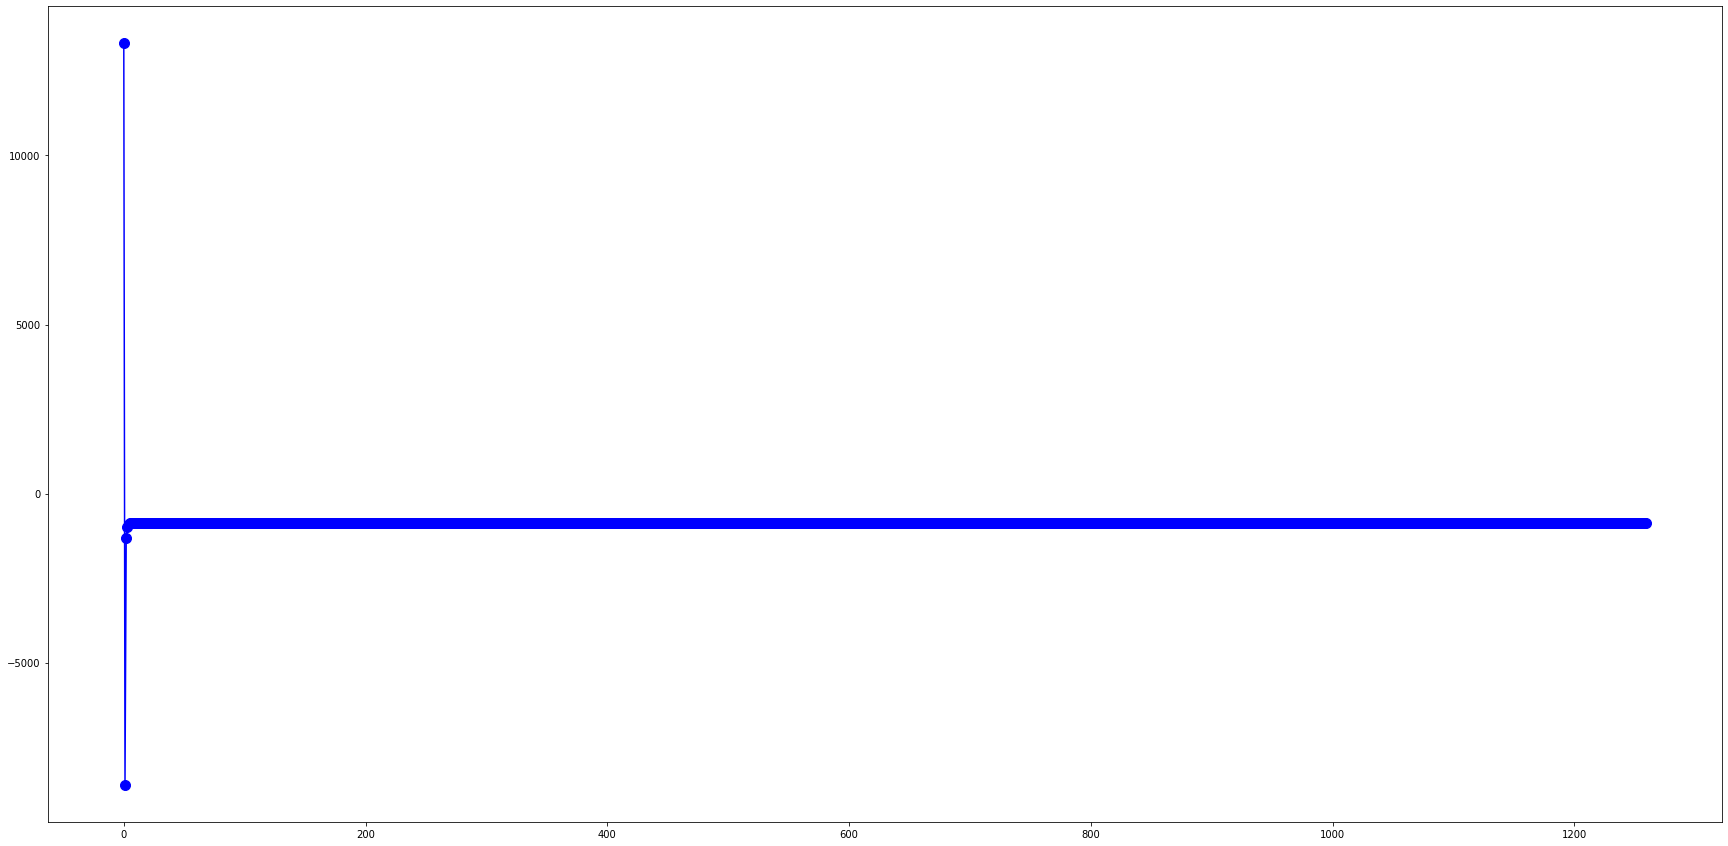

In [1723]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((delta_omega_Im_Iter-Qs/5/T0-1/t_rad_long),'b.-',ms=20)
#axes1.set_ylim([-1e-3,1e-3])

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

In [1724]:
nNpsamp = 100 # number of samples for the number of particles per bunch
nDetunesamp = 800 # number of samples for the detune.
nModes = 2#nBunch # number of modes we want to investigate.
nPar = np.ones(nNpsamp)
Detune = np.zeros(nDetunesamp)
omegac = np.zeros(nDetunesamp)
DetuneMin = detune_final*2*pi*1.5
DetuneMax = -detune_final*2*pi*1.5

for i in range(nDetunesamp):
    Detune[i] = (DetuneMin+(DetuneMax-DetuneMin)/(nDetunesamp-1)*i)/2/pi
    omegac[i] = omegarf[0]+DetuneMin+(DetuneMax-DetuneMin)/(nDetunesamp-1)*i

In [1725]:
# the number of particles per bunch will change the potimized QL
# 
nPar0 = 17.2e10
for i in range(nNpsamp):
    nPar[i] = nPar0/nNpsamp*(i+1)
Prad0 = 9e6
Prad = Prad0*nPar/nPar0
RoQ = np.zeros(nRF)
for i in range(nRF):
    RoQ[i] = 73
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0
NC = 14
Pbeam = Prad0*nPar/nPar0/NC # beam power per cavity
NC = 14
NF = 14
ND = NC-NF
V0 = 23.7e6/NC
# with beam, with drive, with detune.
Urad0 = Prad/(nBunch*nPar*1.6e-19*f0) # radiation caused Voltage
U_loss = Urad0+2*pi*h[0]*f0*RoQ*NC/4*nPar*1.6e-19
Vtot = 23.7e6 # total voltage 

Phis = np.arccos(U_loss/Vtot)+90/180*pi #171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract 'pi' from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2)

Qbeam = Vnew**2/(RoQacc*Pbeam)
R = RoQ*Qbeam*NC
Idc = nPar*nBunch*f0*1.6e-19

In [1726]:
OmegaRe = np.ndarray(shape=(nNpsamp,nDetunesamp,nModes), dtype='d')
OmegaIm = np.ndarray(shape=(nNpsamp,nDetunesamp,nModes), dtype='d')
pmax = 100#1*nBunch # number of samples 

ps = np.array([float(i) for i in range(-pmax,pmax)])
ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python
#mus = np.array([i for i in range(nModes)])#200#h[0]%nBunch # 
mus = np.array([1259*i for i in range(nModes)])#200#h[0]%nBunch # 


In [1727]:
for i in range(nNpsamp):
    for j in range(nDetunesamp):
        for k in range(nModes):
            OmegaRe[i][j][k] = 0
            OmegaIm[i][j][k] = 0

In [1728]:
for i in range(nNpsamp):
    for j in range(nDetunesamp):
        idx = 0
        for mu in mus:
            Omega = Qs*f0*2*pi
            temp = SolveOmega(Omega,ps,mu,nRF,R[i],Qbeam[i],omegac[j],nBunch, nPar[i],r0,eta,Gamma0,T0,Qs,f0,1000,1e-9)
            OmegaRe[i][j][idx] = np.real(temp)
            OmegaIm[i][j][idx] = np.imag(temp)
            idx+=1
    if int((i/nNpsamp)*100)%10==0:
        print(i/nNpsamp*100,'%')

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


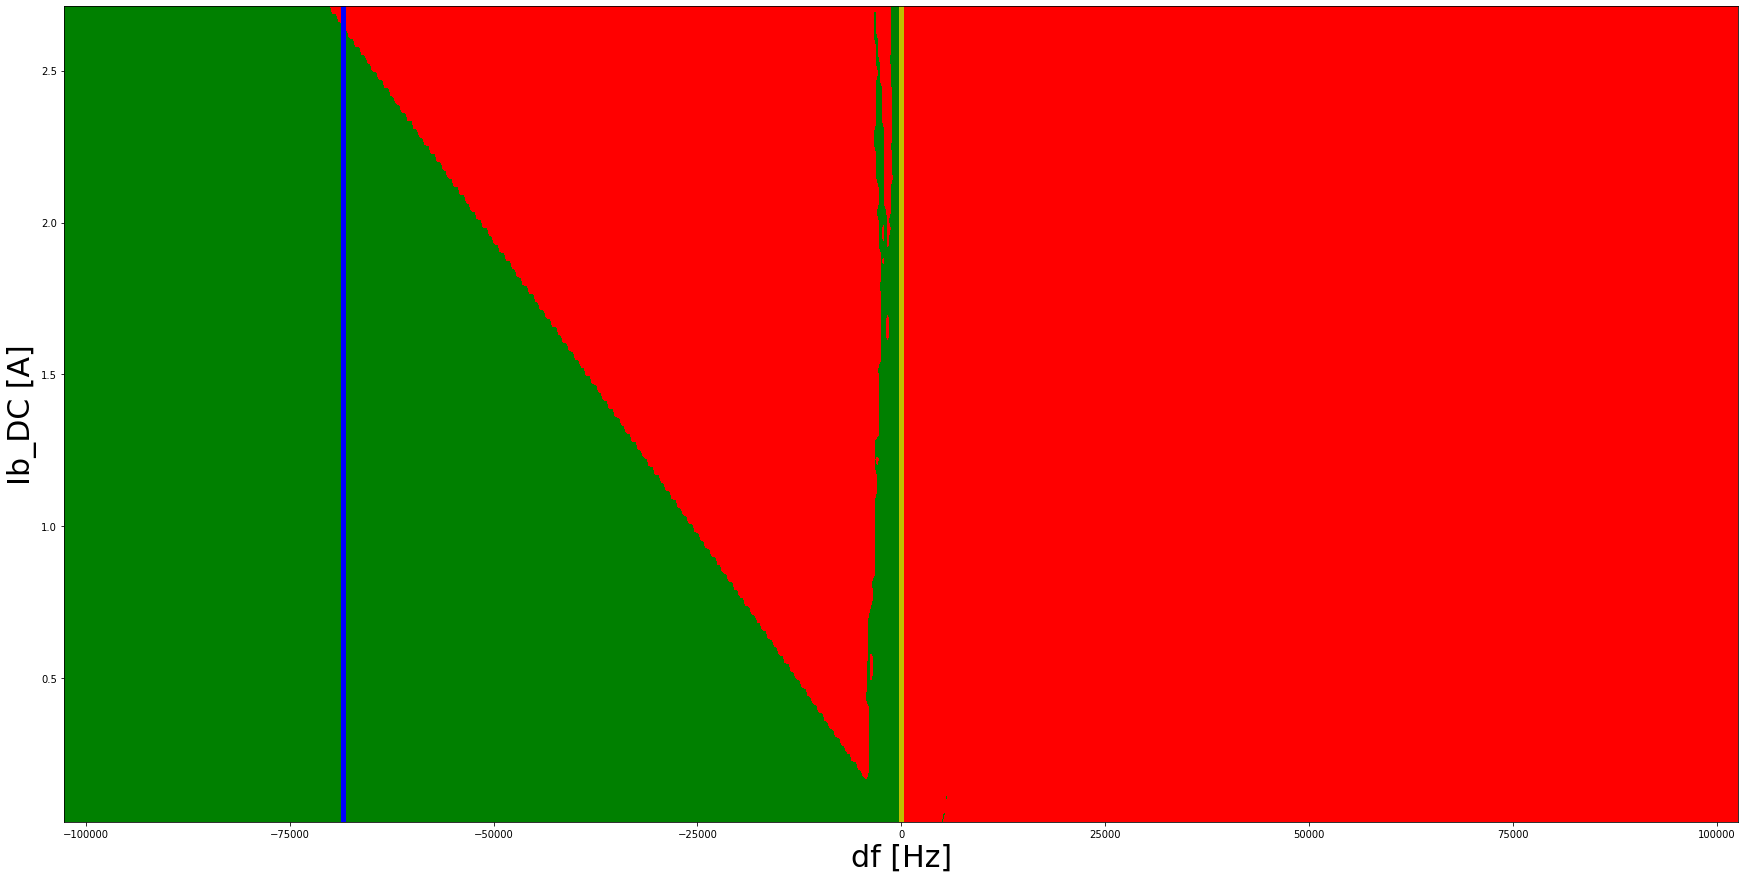

In [1749]:
fig1,axes1 = plt.subplots(1,1)
axes1.contourf(Detune,Idc,OmegaIm[:,:,0],levels=[-1e10,0,1e10],colors=['g','r'])

axes1.axvline(x = 0,linewidth = 5,color='y')
axes1.axvline(x = detune_final,linewidth = 5,color='b')

fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.set_ylabel('Ib_DC [A]',fontsize=30)
axes1.set_xlabel('df [Hz]',fontsize=30)

fn_stab = os.path.join(cwd,'stability_map_mu_0.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()


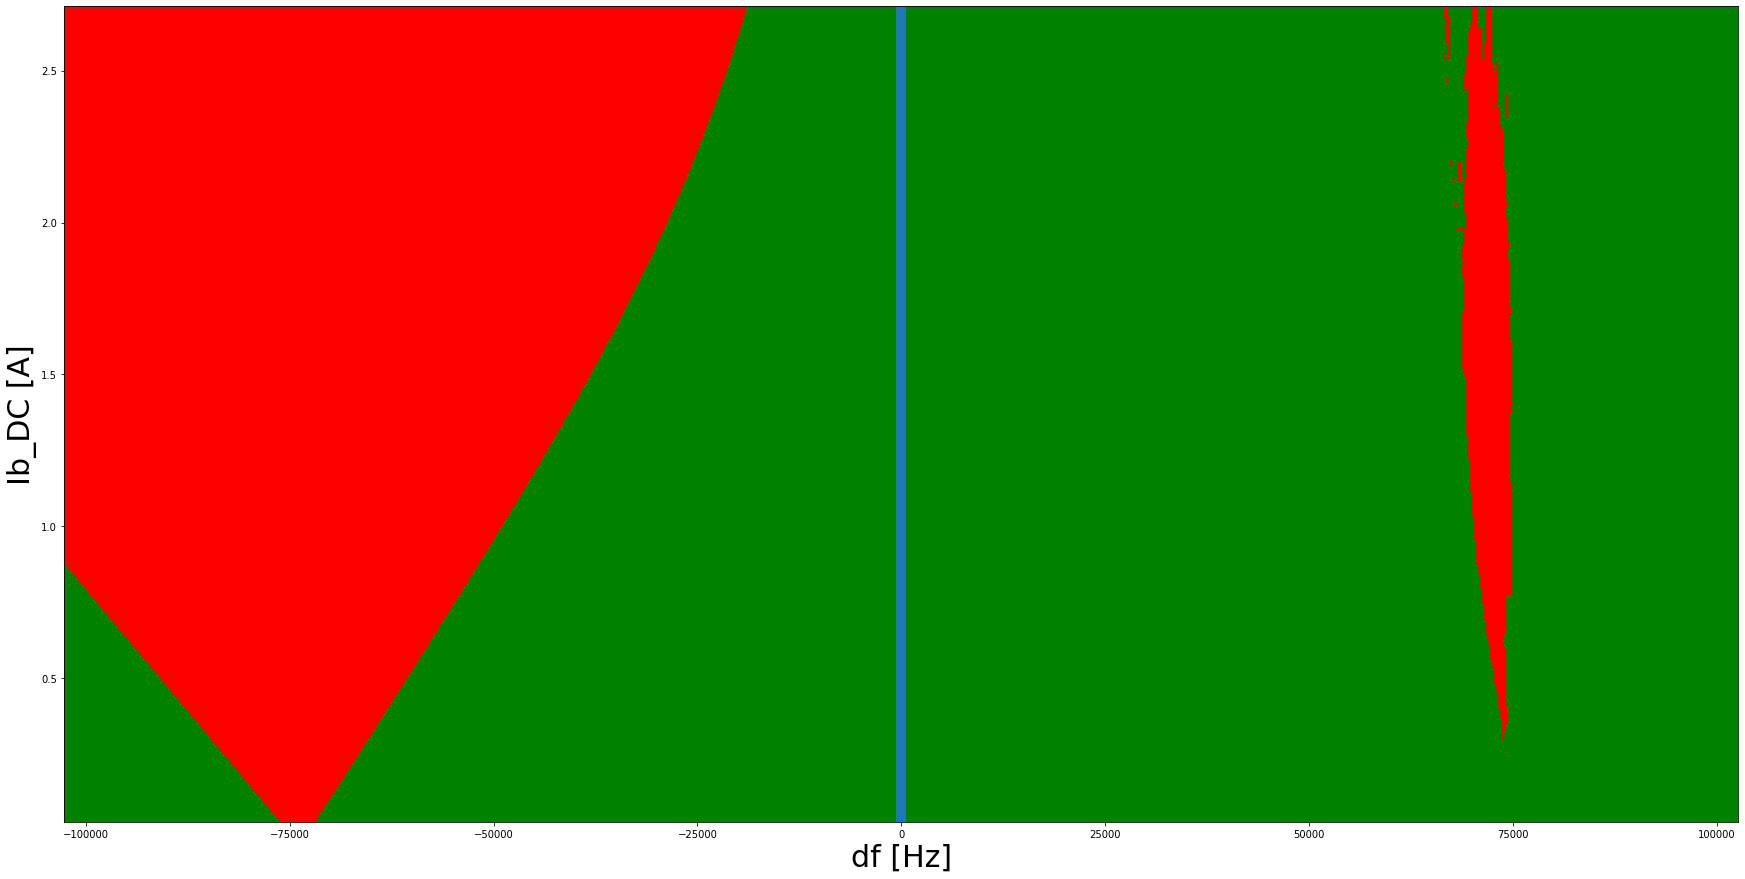

In [1745]:
fig1,axes1 = plt.subplots(1,1)
axes1.contourf(Detune,Idc,OmegaIm[:,:,1]-Qs/5/T0-1/t_rad_long,levels=[-1e10,0,1e10],colors=['g','r'])

axes1.axvline(x = 0,linewidth = 10)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.set_ylabel('Ib_DC [A]',fontsize=30)
axes1.set_xlabel('df [Hz]',fontsize=30)

fn_stab = os.path.join(cwd,'stability_map_mu_1259.jpg')
plt.savefig(fn_stab,bbox_inches='tight')
plt.show()


In [1731]:
# Stable Zone is too small !!

Debug Zone

In [1732]:
(omegac[165]-omegarf[0])/2/pi

-60254.27140339503

In [1733]:
Omega = 1*Qs*f0*2*pi
temp = SolveOmega(Omega,ps,0,nRF,R[99],Qbeam[99],omegac[165],nBunch, nPar[99],r0,eta,Gamma0,T0,Qs,f0,1000,1e-9)
print(temp)

(-7.99549568809298e-06+9949.496276066873j)


In [1734]:
def SolveOmegaDebug(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    LHS = Omega
    ErrRe = np.real(LHS-RHS)
    ErrIm = np.imag(LHS-RHS)
    while(np.sqrt(ErrRe**2+ErrIm**2)>accu and nIter<maxIter):
        omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
        Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
        factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
        RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
        LHS = Omega
        ErrRe = np.real(LHS-RHS)
        ErrIm = np.imag(LHS-RHS)
        Omega-=ErrRe*1+ErrIm*1j
        nIter+=1
    return Omega   
    print(Omega)
    print((ErrRe))
    print((ErrIm))
    print(nIter)


In [1735]:
Iidx = 99
Omegaidx = 165
Omega = 1*Qs*f0*2*pi
temp = SolveOmegaDebug(Omega,ps,0,nRF,R[Iidx],Qbeam[Iidx],omegac[Omegaidx],nBunch, nPar[Iidx],r0,eta,Gamma0,T0,Qs,f0,1000,1e-19)
print(temp)

(7.984107619270258e-06-10605.201999387413j)


In [1736]:
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 100#1*nBunch # number of samples 

mus = np.array([i for i in range(1)])#200#h[0]%nBunch # 
delta_omega_Re = np.zeros(nBunch)
delta_omega_Im = np.zeros(nBunch)
i=0
#print('Mode #, ','Delta_Omega_Re, ','Delta_Omega_Im', 'Growth_Time')
for mu in mus:
    ps = np.array([float(i) for i in range(-pmax,pmax)])
    ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

    # for the calculation of real part of Omega
    p_M_omega0 = ps*nBunch*2*np.pi*f0
    Zs0 = np.array([Zparallel(R[Iidx],Qbeam[Iidx],omegac[Omegaidx],p_M_omega0) for i in range(nRF)])
    factor1 = nBunch*nPar[Iidx]*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
    delta_omegas = 0*factor1*np.sum(p_M_omega0*np.imag(Zs0)) # this is zero if optimumly compensated 
    omegas = Qs*2*pi*f0+delta_omegas

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
    Zs1 = np.array([Zparallel(R[Iidx],Qbeam[Iidx],omegac[Omegaidx],omegas1) for i in range(nRF)])
    factor1 = nBunch*nPar[Iidx]*r0*eta/(2*Gamma0*T0**2*omegas)
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*nPar[Iidx]*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[Iidx],Qbeam[Iidx],omegac[Omegaidx],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[i] = deltaOmegaRe+omegas
    delta_omega_Im[i] = deltaOmegaIm
    print(i,deltaOmegaRe+omegas,';',deltaOmegaIm, ';',1/deltaOmegaIm)
    i+=1


0 11246.859988299704 ; -332.9386856366798 ; -0.0030035560394181785


In [1737]:
def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1
    
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    F = Omega-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
    LHS = Omega
    ErrRe = np.real(LHS-RHS)
    ErrIm = np.imag(LHS-RHS)
    while(np.sqrt(ErrRe**2+ErrIm**2)>accu and nIter<maxIter):
        omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
        Zs = np.array([Zparallel(R,QL,omegac,omegasamp) for i in range(nRF)])
        factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
        RHS = np.sqrt(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)
        LHS = Omega
        ErrRe = np.real(LHS-RHS)
        ErrIm = np.imag(LHS-RHS)
        Omega-=ErrRe*1+ErrIm*1j
        nIter+=1
    return Omega

    print(Omega)
    print((ErrRe))
    print((ErrIm))
    print(nIter)


In [1738]:
OmegaRe[99,:,0]

array([ 1.46733130e+04,  1.46332559e+04,  1.45928923e+04,  1.45522181e+04,
        1.45112293e+04,  1.44699217e+04,  1.44282912e+04,  1.43863334e+04,
        1.43440439e+04,  1.43014183e+04,  1.42584519e+04,  1.42151402e+04,
        1.41714782e+04,  1.41274612e+04,  1.40830842e+04,  1.40383420e+04,
        1.39932296e+04,  1.39477416e+04,  1.39018725e+04,  1.38556170e+04,
        1.38089692e+04,  1.37619234e+04,  1.37144736e+04,  1.36666139e+04,
        1.36183380e+04,  1.35696395e+04,  1.35205121e+04,  1.34709489e+04,
        1.34209433e+04,  1.33704883e+04,  1.33195766e+04,  1.32682010e+04,
        1.32163540e+04,  1.31640278e+04,  1.31112147e+04,  1.30579064e+04,
        1.30040947e+04,  1.29497711e+04,  1.28949267e+04,  1.28395527e+04,
        1.27836397e+04,  1.27271784e+04,  1.26701588e+04,  1.26125711e+04,
        1.25544049e+04,  1.24956495e+04,  1.24362941e+04,  1.23763274e+04,
        1.23157378e+04,  1.22545135e+04,  1.21926420e+04,  1.21301107e+04,
        1.20669065e+04,  

In [1739]:
R[Iidx]

31205000.0

In [1740]:
Qbeam[Iidx]

30533.268101761252

In [1741]:
QL

[30533.268101761252]

In [1742]:
Qs/5/T0

846.9853266375198

In [1743]:
1/t_rad_long

18.22821728034998